In [14]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
import os
import seaborn as sns
import random 
import scipy as sc
import statsmodels.api as sm
import scipy.stats as stats
import cartopy.crs as ccrs
import pygrib
import cfgrib
import glob

sns.set_theme(style="white")
sns.set_style("white")

random.seed(10)

25/07 update
1. avg? along 8 timesteps
(so the date should be?)
8 TIME STEPS PER DAY I.E. 3HR/STEP
2. choose the new top 10 and avg again

3. use seaborn when possible
seaborn.kdeplot or seaborn.jointplot could solve the problem easily
an easier one is xarray.controuf plot (less freedom)

In [15]:

class Data():
    def get_eps_data(experiments, inidate='2022-02-16'):
        """
        Function to load comlete data of simulations on surface level since
        xr has a bug that prevents using
        this as a simpler solution

        Input:
        ------
        experiments: list of strings, list of experiments to import,
                e.g. ['pi', 'curr', 'incr']

        Output:
        -------
        eps: list of xarrays, data and metadata of operational forecasts,
        each list entry is one experiment
        """

        directory = {'pi': '/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/EXP/pi/EU025/sfc/',
                    'curr': '/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/ENS/EU025/sfc/',
                    'incr': '/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/EXP/incr/EU025/sfc/'}

        eps = {}
        for experiment in experiments:
            exp_eps = []
            for c, cont in enumerate(['cf', 'pf']):
                for files in glob.glob(directory[experiment]
                                        + cont + '/*'
                                        + inidate + '*.nc'):
                    print(files)
                    data = xr.open_dataset(files)
                    exp_eps.append(Data.preproc_ds(data.get(['fg10', 'msl',
                                                                'u10', 'v10',
                                                                'u100', 'v100'])))

            eps[experiment] = xr.concat(exp_eps, dim='number').squeeze()

        return eps
    

    def preproc_ds(ds):
        """
        Main pre-processing function
        Writtten by Nick Leach.

        Input:
        ------

        Output:
        -------
        """

        # accumulated variables & scaling factors
        accumulated_vars = {'tp': 60 * 60 * 24 * 1e3,
                            'ttr': 1,
                            'tsr': 1,
                            'str': 1,
                            'ssr': 1,
                            'e': 1}
        accumulated_var_newunits = {'tp': 'mm day$^{-1}$',
                                    'ttr': 'W m$^{-2}$',
                                    'tsr': 'W m$^{-2}$',
                                    'str': 'W m$^{-2}$',
                                    'ssr': 'W m$^{-2}$',
                                    'e': 'm s$^{-1}$'}
        ds = ds.copy().squeeze()
        # set up aux data
        inidate = pd.to_datetime(ds.time[0].values)
        # expand dimensions to include extra info
        if not 'hDate' in ds:
            ds = ds.expand_dims({'inidate': [inidate]}).copy()

        if not 'number' in ds:
            ds = ds.expand_dims({'number': [0]}).copy()

        # put time dimension at front
        ds = ds.transpose('time', ...)
        ds = ds.copy(deep=True)

        # convert accumulated variables into instantaneous
        for var, sf in accumulated_vars.items():
            if var in ds.keys():
                ds[var].loc[dict(time=ds.time[1:])] = Data.accum2rate(ds[var]) * sf
                # set first value to equal zero,
                # should be zero but isn't always
                ds[var].loc[dict(time=ds.time[0])] = 0
                ds[var].attrs['units'] = accumulated_var_newunits[var]
        return ds
        

Step 1: import the data (select the 16th with the same directory)
Step 2: select windstress data ()
Step 3: filter data (51 ensemble with 95% windgust and choose top 5)
Step 4: plot

In [16]:
da_pi = Data.get_eps_data(['pi'])
da_curr = Data.get_eps_data(['curr'])
da_incr = Data.get_eps_data(['incr'])


/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/EXP/pi/EU025/sfc/cf/b2ns_2022-02-16.nc
/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/EXP/pi/EU025/sfc/pf/b2ns_2022-02-16.nc
/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/ENS/EU025/sfc/cf/1_2022-02-16.nc
/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/ENS/EU025/sfc/pf/1_2022-02-16.nc
/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/EXP/incr/EU025/sfc/cf/b2nt_2022-02-16.nc
/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/EXP/incr/EU025/sfc/pf/b2nt_2022-02-16.nc


In [17]:
wind_gusts_pi = da_pi['pi'].sel(time='2022-02-16').fg10
wind_gusts_curr = da_curr['curr'].sel(time='2022-02-16').fg10
wind_gusts_incr = da_incr['incr'].sel(time='2022-02-16').fg10

In [18]:
wind_gusts_pi.head

<bound method DataArray.head of <xarray.DataArray 'fg10' (time: 8, number: 51, latitude: 163, longitude: 289)>
array([[[[ 0.       ,  0.       ,  0.       , ...,  0.       ,
           0.       ,  0.       ],
         [ 0.       ,  0.       ,  0.       , ...,  0.       ,
           0.       ,  0.       ],
         [ 0.       ,  0.       ,  0.       , ...,  0.       ,
           0.       ,  0.       ],
         ...,
         [ 0.       ,  0.       ,  0.       , ...,  0.       ,
           0.       ,  0.       ],
         [ 0.       ,  0.       ,  0.       , ...,  0.       ,
           0.       ,  0.       ],
         [ 0.       ,  0.       ,  0.       , ...,  0.       ,
           0.       ,  0.       ]],

        [[ 0.       ,  0.       ,  0.       , ...,  0.       ,
           0.       ,  0.       ],
         [ 0.       ,  0.       ,  0.       , ...,  0.       ,
           0.       ,  0.       ],
         [ 0.       ,  0.       ,  0.       , ...,  0.       ,
           0.       ,  0. 

In [19]:
lat = da_pi['pi'].sel(time='2022-02-16 12').latitude.values
lon = da_pi['pi'].sel(time='2022-02-16 12').longitude.values

In [75]:
'''
avg_wg_pi = []
pi_max = []
for num in wind_gusts_pi.number:
    avg_wg_pi.append(wind_gusts_pi.sel(number=num).quantile(0.95))
    pi_max.append(max(wind_gusts_pi.sel(number=num).quantile(0.95)))

avg_wg_pi
pi_max
'''

avg_wg_pi = wind_gusts_pi.quantile(0.95,dim=['latitude','longitude','time'])
avg_wg_curr = wind_gusts_curr.quantile(0.95,dim=['latitude','longitude','time'])
avg_wg_incr = wind_gusts_incr.quantile(0.95,dim=['latitude','longitude','time'])

max_time= '2022-02-16T21'

wd_pi = wind_gusts_pi.sortby(avg_wg_pi,ascending=False).sel(number=wind_gusts_pi.sortby(avg_wg_pi,ascending=False).number[:10]).sel(time=max_time).sum(dim='number')/10
wd_curr = wind_gusts_curr.sortby(avg_wg_curr,ascending=False).sel(number=wind_gusts_curr.sortby(avg_wg_curr,ascending=False).number[:10]).sel(time=max_time).sum(dim='number')/10
wd_incr = wind_gusts_incr.sortby(avg_wg_incr,ascending=False).sel(number=wind_gusts_incr.sortby(avg_wg_curr,ascending=False).number[:10]).sel(time=max_time).sum(dim='number')/10


In [67]:
wind_gusts_pi.sel(number=34).quantile(0.95,dim=['longitude','latitude'])



<xarray.DataArray 'fg10' (time: 8)>
array([ 0.        , 21.60976067, 22.71683292, 23.1351265 , 23.31410885,
       23.84518433, 24.42485867, 24.51294785])
Coordinates:
  * time      (time) datetime64[ns] 2022-02-16 ... 2022-02-16T21:00:00
    quantile  float64 0.95

1. FOR quantile function, I have no idea why the output is flat--I mean, did I select a specific number of experiment? No!

OKAY, DATA ARRAY COLLAPSE ALONG DIMENSION, SO HERE WE COLLASPE ALONG LON/LAT/TIME TO GET 0.95 PERCENTILE IN EACH ENSEMBLE NUMBER.

2. For plots like these, getting enough timesteps is very critical

3. sel() bit is slightly dodgy but I have no other way to deal with it. Should try other indexing method but my brain is messed up by all the matlab/pandas/numpy thingies

In [21]:
wd_pi

<xarray.DataArray 'fg10' (time: 8, latitude: 163, longitude: 289)>
array([[[ 0.       ,  0.       ,  0.       , ...,  0.       ,
          0.       ,  0.       ],
        [ 0.       ,  0.       ,  0.       , ...,  0.       ,
          0.       ,  0.       ],
        [ 0.       ,  0.       ,  0.       , ...,  0.       ,
          0.       ,  0.       ],
        ...,
        [ 0.       ,  0.       ,  0.       , ...,  0.       ,
          0.       ,  0.       ],
        [ 0.       ,  0.       ,  0.       , ...,  0.       ,
          0.       ,  0.       ],
        [ 0.       ,  0.       ,  0.       , ...,  0.       ,
          0.       ,  0.       ]],

       [[ 4.1723413,  4.2499228,  4.4018455, ..., 16.986116 ,
         17.207565 , 17.408    ],
        [ 3.3225312,  3.8630638,  4.3083277, ..., 18.403952 ,
         18.618223 , 18.853245 ],
        [ 3.9099114,  3.3685899,  3.6610541, ..., 19.426966 ,
         19.537207 , 19.698587 ],
...
        [ 5.874761 ,  5.879752 ,  6.09262  , ...,  5.5083055,
          5.656727 ,  6.0906067],
        [ 6.18719  ,  6.4087267,  6.5335054, ...,  6.2061033,
          6.8854246,  6.651629 ],
        [ 6.639371 ,  6.690596 ,  6.6723824, ...,  6.8649354,
          7.188834 ,  7.3052073]],

       [[ 6.6819267,  6.337713 ,  6.1200275, ..., 14.840971 ,
         14.946487 , 15.038167 ],
        [ 5.2276635,  5.782556 ,  6.469409 , ..., 15.57861  ,
         15.732462 , 15.8617935],
        [ 3.758075 ,  3.5300584,  4.567079 , ..., 16.518173 ,
         16.703808 , 16.897152 ],
        ...,
        [ 6.74366  ,  6.6815767,  6.53981  , ...,  5.087648 ,
          5.2865057,  5.9895577],
        [ 6.977806 ,  6.9179993,  6.8664236, ...,  4.58503  ,
          5.632821 ,  6.031064 ],
        [ 7.170359 ,  6.967035 ,  6.9340234, ...,  4.3901124,
          5.326434 ,  6.0969114]]], dtype=float32)
Coordinates:
    inidate    datetime64[ns] 2022-02-16
  * longitude  (longitude) float32 -27.0 -26.75 -26.5 -26.25 ... 44.5 44.75 45.0
  * latitude   (latitude) float32 73.5 73.25 73.0 72.75 ... 33.5 33.25 33.0
  * time       (time) datetime64[ns] 2022-02-16 ... 2022-02-16T21:00:00

"\nfig,ax = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree()))\nax.contourf(lon, lat, wd_pi)\nax.coastlines()\nplt.xlabel('longtitude')\nplt.ylabel('latittude')\nfig.colorbar(mappable=None)\n"

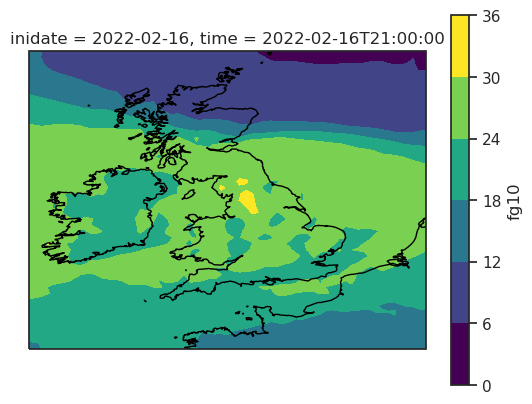

In [76]:
uk = [-11, 5, 48, 60]

fig,ax = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree()))
xr.plot.contourf(wd_pi)
ax.coastlines()
ax.set_extent(uk)
ax.get_xticklabels
ax.get_yticklabels
'''
fig,ax = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree()))
ax.contourf(lon, lat, wd_pi)
ax.coastlines()
plt.xlabel('longtitude')
plt.ylabel('latittude')
fig.colorbar(mappable=None)
'''

We can also use sns.kdeplot or sns.jointplot as well (cuz matplotlib really doesn't work well)
It seems like jointplot doesn't quite work as well.
Maybe it is time to use geoplot 
NOOOO

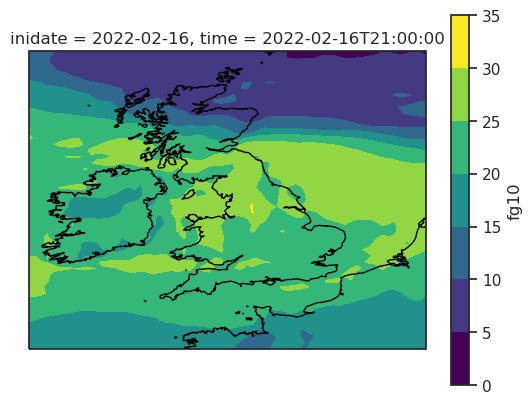

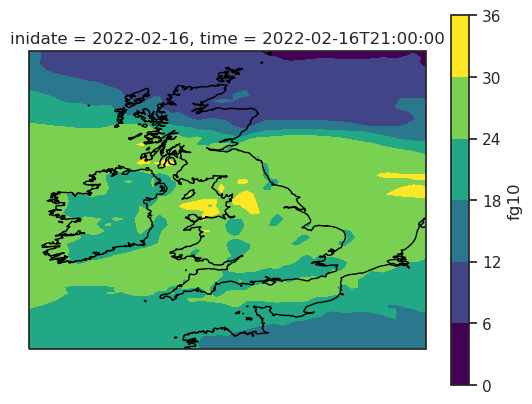

In [77]:
fig,ax = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree()))
xr.plot.contourf(wd_curr)
ax.coastlines()
plt.xlabel('longtitude')
plt.ylabel('latittude')
ax.set_extent(uk)


fig,ax = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree()))
xr.plot.contourf(wd_incr)
ax.coastlines()
plt.xlabel('longtitude')
plt.ylabel('latittude')

ax.set_extent(uk)
